Project #1


In [1]:
# Import 
import warnings
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from census import Census
import requests

#To ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# Import U.S. Census API Key
from config import api_key

# Create an instance of the Census library
c=Census(
    api_key,
    year = 2022
)

In [108]:
# File Path
general_data_to_load = Path("Resources/Hospital_General_Information.csv")
score_data_to_load = Path("Resources/hvbp_tps.csv")
locations_data_to_load=Path("Resources/hospital_locations.csv")

# Read School and Student Data File and store into Pandas DataFrames
general_data = pd.read_csv(general_data_to_load, encoding='latin1')
score_data = pd.read_csv(score_data_to_load)
locations_data=pd.read_csv(locations_data_to_load)

# Combine the data from the files into a single dataset
hospital_data_complete = pd.merge(general_data, score_data, how="left", left_on='Provider ID', right_on="Facility ID")

# Make an output for the new dataset
output_file_path= 'hospital_data_complete.csv'
hospital_data_complete.to_csv(output_file_path, index=False)
hospital_data_complete=pd.read_csv(output_file_path)


hospital_data_complete

,Provider ID,Hospital Name,Address_x,City,State_x,ZIP Code_x,County Name,Phone Number,Hospital Type,Hospital Ownership,...,County/Parish,Unweighted Normalized Clinical Outcomes Domain Score,Weighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Weighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Weighted Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,HOUSTON,38.33333333,9.583333333,16,4,8,2,0,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,MARSHALL,28,7,6,1.5,22,5.5,30,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,LAUDERDALE,0,0,6,1.5,48,12,0,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,...,COVINGTON,6.666666667,2.222222222,24,8,Not Available,Not Available,50,16.66666667,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,670118,FIRST TEXAS HOSPITAL,9922 LOUETTA RD,HOUSTON,TX,77070,HARRIS,8442641435,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4808,640001,LBJ TROPICAL MEDICAL CENTER,FAGAALU VILLAGE,PAGO PAGO,AS,96799,NaN,6846334590,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4809,650001,GUAM MEMORIAL HOSPITAL AUTHORITY,85O GOV CARLOS G CAMACHO ROAD,TAMUNING,GU,96913,NaN,6716472552,Acute Care Hospitals,Government - Local,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4810,650003,GUAM REGIONAL MEDICAL CITY,133 ROUTE 3,DEDEDO,GU,96929,NaN,6716455500,Acute Care Hospitals,Voluntary non-profit - Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Calculate the number of hospitals
hospital_unique_count=hospital_data_complete['Hospital Name'].nunique()
print("Number of unique hospitals:",hospital_unique_count)
print (hospital_data_complete.columns)

Number of unique hospitals: 4623
Index(['Provider ID', 'Hospital Name', 'Address_x', 'City', 'State_x',
       'ZIP Code_x', 'County Name', 'Phone Number', 'Hospital Type',
       'Hospital Ownership', 'Emergency Services',
       'Meets criteria for meaningful use of EHRs', 'Hospital overall rating',
       'Hospital overall rating footnote', 'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison',
       'Safety of care national comparison footnote',
       'Readmission national comparison',
       'Readmission national comparison footnote',
       'Patient experience national comparison',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national com

In [5]:
#del hospital_data_complete['Facility Name'] #,['Address_y'], ['City/Town'],
       #['State_y'], ['ZIP Code_y'], ['County/Parish']

# Drop all rows with missing information
#hospital_data_complete = hospital_data_complete.dropna(how='any')
#hospital_data_complete
# Identify incomplete rows
hospital_data_complete.count()

Provider ID                                                         4812
Hospital Name                                                       4812
Address_x                                                           4812
City                                                                4812
State_x                                                             4812
ZIP Code_x                                                          4812
County Name                                                         4797
Phone Number                                                        4812
Hospital Type                                                       4812
Hospital Ownership                                                  4812
Emergency Services                                                  4812
Meets criteria for meaningful use of EHRs                           4669
Hospital overall rating                                             4812
Hospital overall rating footnote                   

In [62]:
hospital_data_df = pd.DataFrame({
    'Provider ID': hospital_data_complete['Provider ID'],
    'Hospital Name': hospital_data_complete['Hospital Name'],
    'Address': hospital_data_complete['Address_x'],  # Renamed to 'Address'
    'City': hospital_data_complete['City'],
    'State': hospital_data_complete['State_x'],      # Renamed to 'State'
    'ZIP Code': hospital_data_complete['ZIP Code_x'],# Renamed to 'Zip Code'
    'County Name': hospital_data_complete['County Name'],
    'Phone Number': hospital_data_complete['Phone Number'],
    'Hospital Type': hospital_data_complete['Hospital Type'],
    'Hospital Ownership': hospital_data_complete['Hospital Ownership'],
    'Emergency Services': hospital_data_complete['Emergency Services'],
    'Meets criteria for meaningful use of EHRs': hospital_data_complete['Meets criteria for meaningful use of EHRs'],
    'Hospital overall rating': hospital_data_complete['Hospital overall rating'],
    'Weighted Normalized Clinical Outcomes Domain Score': hospital_data_complete['Weighted Normalized Clinical Outcomes Domain Score'],
    'Weighted Person And Community Engagement Domain Score': hospital_data_complete['Weighted Person And Community Engagement Domain Score'],
    'Weighted Safety Domain Score': hospital_data_complete['Weighted Safety Domain Score'],
    'Weighted Efficiency And Cost Reduction Domain Score': hospital_data_complete['Weighted Efficiency And Cost Reduction Domain Score'],
    'Total Performance Score': hospital_data_complete['Total Performance Score']
})

hospital_data_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Weighted Normalized Clinical Outcomes Domain Score,Weighted Person And Community Engagement Domain Score,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,9.583333333,4,2,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,7,1.5,5.5,7.5,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,0,1.5,12,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,2.222222222,8,Not Available,16.66666667,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,670118,FIRST TEXAS HOSPITAL,9922 LOUETTA RD,HOUSTON,TX,77070,HARRIS,8442641435,Acute Care Hospitals,Proprietary,Yes,NaN,Not Available,NaN,NaN,NaN,NaN,NaN
4808,640001,LBJ TROPICAL MEDICAL CENTER,FAGAALU VILLAGE,PAGO PAGO,AS,96799,NaN,6846334590,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,Not Available,NaN,NaN,NaN,NaN,NaN
4809,650001,GUAM MEMORIAL HOSPITAL AUTHORITY,85O GOV CARLOS G CAMACHO ROAD,TAMUNING,GU,96913,NaN,6716472552,Acute Care Hospitals,Government - Local,Yes,Y,3,NaN,NaN,NaN,NaN,NaN
4810,650003,GUAM REGIONAL MEDICAL CITY,133 ROUTE 3,DEDEDO,GU,96929,NaN,6716455500,Acute Care Hospitals,Voluntary non-profit - Private,Yes,NaN,Not Available,NaN,NaN,NaN,NaN,NaN


In [30]:
# Drop all rows with missing information
# First, drop rows with any NaN values
hospital_data_df = hospital_data_df.dropna(how='any')

# Then, drop rows where 'Not Available' is present in any column
hospital_data_df = hospital_data_df[~hospital_data_df.isin(['Not Available']).any(axis=1)]

columns_to_convert = ['Hospital overall rating',
                      'Weighted Normalized Clinical Outcomes Domain Score',
                      'Weighted Person And Community Engagement Domain Score',
                      'Weighted Safety Domain Score',
                      'Weighted Efficiency And Cost Reduction Domain Score']

new_hospital_data_df = hospital_data_df.copy()  # Copy the original DataFrame

for col in columns_to_convert:

    new_hospital_data_df[col] = new_hospital_data_df[col].astype(float)

new_hospital_data_df.dtypes
new_hospital_data_df
new_hospital_data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 0 to 4793
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Provider ID                                            2017 non-null   int64  
 1   Hospital Name                                          2017 non-null   object 
 2   Address                                                2017 non-null   object 
 3   City                                                   2017 non-null   object 
 4   State                                                  2017 non-null   object 
 5   ZIP Code                                               2017 non-null   int64  
 6   County Name                                            2017 non-null   object 
 7   Phone Number                                           2017 non-null   int64  
 8   Hospital Type                                        

In [65]:
hospital_unweighted = pd.DataFrame({
    'Provider ID': hospital_data_complete['Provider ID'],
    'Hospital Name': hospital_data_complete['Hospital Name'],
    'Address': hospital_data_complete['Address_x'],  # Renamed to 'Address'
    'City': hospital_data_complete['City'],
    'State': hospital_data_complete['State_x'],      # Renamed to 'State'
    'ZIP Code': hospital_data_complete['ZIP Code_x'],# Renamed to 'Zip Code'
    'County Name': hospital_data_complete['County Name'],
    'Phone Number': hospital_data_complete['Phone Number'],
    'Hospital Type': hospital_data_complete['Hospital Type'],
    'Hospital Ownership': hospital_data_complete['Hospital Ownership'],
    'Emergency Services': hospital_data_complete['Emergency Services'],
    'Meets criteria for meaningful use of EHRs': hospital_data_complete['Meets criteria for meaningful use of EHRs'],
    'Hospital overall rating': hospital_data_complete['Hospital overall rating'],
    'Unweighted Normalized Clinical Outcomes Domain Score': hospital_data_complete['Unweighted Normalized Clinical Outcomes Domain Score'],
    'Unweighted Person And Community Engagement Domain Score': hospital_data_complete['Unweighted Person And Community Engagement Domain Score'],
    'Unweighted Normalized Safety Domain Score': hospital_data_complete['Unweighted Normalized Safety Domain Score'],
    'Unweighted Normalized Efficiency And Cost Reduction Domain Score': hospital_data_complete['Unweighted Normalized Efficiency And Cost Reduction Domain Score'],
    'Total Performance Score': hospital_data_complete['Total Performance Score']
})

hospital_unweighted

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Unweighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,38.33333333,16,8,0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,28,6,22,30,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,0,6,48,0,13.500000
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,6.666666667,24,Not Available,50,26.888889
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,670118,FIRST TEXAS HOSPITAL,9922 LOUETTA RD,HOUSTON,TX,77070,HARRIS,8442641435,Acute Care Hospitals,Proprietary,Yes,NaN,Not Available,NaN,NaN,NaN,NaN,NaN
4808,640001,LBJ TROPICAL MEDICAL CENTER,FAGAALU VILLAGE,PAGO PAGO,AS,96799,NaN,6846334590,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,Not Available,NaN,NaN,NaN,NaN,NaN
4809,650001,GUAM MEMORIAL HOSPITAL AUTHORITY,85O GOV CARLOS G CAMACHO ROAD,TAMUNING,GU,96913,NaN,6716472552,Acute Care Hospitals,Government - Local,Yes,Y,3,NaN,NaN,NaN,NaN,NaN
4810,650003,GUAM REGIONAL MEDICAL CITY,133 ROUTE 3,DEDEDO,GU,96929,NaN,6716455500,Acute Care Hospitals,Voluntary non-profit - Private,Yes,NaN,Not Available,NaN,NaN,NaN,NaN,NaN


In [67]:
# First, drop rows with any NaN values
hospital_unweighted = hospital_unweighted.dropna(how='any')

# Then, drop rows where 'Not Available' is present in any column
hospital_unweighted = hospital_unweighted[~hospital_unweighted.isin(['Not Available']).any(axis=1)]

columns_to_convert = ['Hospital overall rating',
                      'Unweighted Normalized Clinical Outcomes Domain Score',
                      'Unweighted Person And Community Engagement Domain Score',
                      'Unweighted Normalized Safety Domain Score',
                      'Unweighted Normalized Efficiency And Cost Reduction Domain Score']

new_hospital_unweighted = hospital_unweighted.copy()  # Copy the original DataFrame

for col in columns_to_convert:

    new_hospital_unweighted[col] = new_hospital_unweighted[col].astype(float)


new_hospital_unweighted


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Unweighted Normalized Clinical Outcomes Domain Score,Unweighted Person And Community Engagement Domain Score,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,38.333333,16.0,8.0,0.0,15.583333
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,28.000000,6.0,22.0,30.0,21.500000
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2.0,0.000000,6.0,48.0,0.0,13.500000
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2.0,15.000000,16.0,16.0,10.0,14.250000
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,Yes,Y,3.0,12.500000,14.0,70.0,0.0,24.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,BELL,2549538342,Acute Care Hospitals,Proprietary,Yes,Y,4.0,10.000000,26.0,50.0,0.0,21.500000
4780,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,COLLIN,4697642200,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,38.000000,23.0,46.0,10.0,29.250000
4782,670085,TEXAS HEALTH HARRIS METHODIST HOSPITAL ALLIANCE,10864 TEXAS HEALTH TRAIL,FORT WORTH,TX,76244,TARRANT,6822122000,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,7.500000,16.0,86.0,0.0,27.375000
4784,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,BRAZOS,9796913701,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,18.333333,36.0,28.0,10.0,23.083333


In [8]:
rating_by_state_count = new_hospital_data_df.groupby('State')['Hospital overall rating'].count()
clinical_by_state_count = new_hospital_data_df.groupby('State')['Weighted Normalized Clinical Outcomes Domain Score'].count()
person_score_by_state_count = new_hospital_data_df.groupby('State')['Weighted Person And Community Engagement Domain Score'].count()
safety_by_state_count = new_hospital_data_df.groupby('State')['Weighted Safety Domain Score'].count()
efficiency_by_state_count = new_hospital_data_df.groupby('State')['Weighted Efficiency And Cost Reduction Domain Score'].count()
performance_total_by_state_count = new_hospital_data_df.groupby('State')['Total Performance Score'].count()

by_state_df_count=pd.DataFrame({'Hospital Rate Count':rating_by_state_count,'Weighted Normalized Clinical Outcomes Domain Score Count':clinical_by_state_count,
                          'Weighted Person And Community Engagement Domain Score Count':person_score_by_state_count, 'Weighted Safety Domain Score Count':safety_by_state_count,
                          'Weighted Efficiency And Cost Reduction Domain Score Count':efficiency_by_state_count, 
                          'Total Performance Score Count':performance_total_by_state_count})

by_state_df_count

,Hospital Rate Count,Weighted Normalized Clinical Outcomes Domain Score Count,Weighted Person And Community Engagement Domain Score Count,Weighted Safety Domain Score Count,Weighted Efficiency And Cost Reduction Domain Score Count,Total Performance Score Count
State,,,,,,
AK,5,5,5,5,5,5
AL,39,39,39,39,39,39
AR,23,23,23,23,23,23
AZ,41,41,41,41,41,41
CA,194,194,194,194,194,194
CO,33,33,33,33,33,33
CT,21,21,21,21,21,21
DC,5,5,5,5,5,5
DE,5,5,5,5,5,5


In [9]:
rating_by_state = new_hospital_data_df.groupby('State')['Hospital overall rating'].mean()
clinical_by_state = new_hospital_data_df.groupby('State')['Weighted Normalized Clinical Outcomes Domain Score'].mean()
person_score_by_state = new_hospital_data_df.groupby('State')['Weighted Person And Community Engagement Domain Score'].mean()
safety_by_state = new_hospital_data_df.groupby('State')['Weighted Safety Domain Score'].mean()
efficiency_by_state = new_hospital_data_df.groupby('State')['Weighted Efficiency And Cost Reduction Domain Score'].mean()
performance_total_by_state = new_hospital_data_df.groupby('State')['Total Performance Score'].mean()

by_state_df=pd.DataFrame({'Hospital Rate Average':rating_by_state,'Weighted Normalized Clinical Outcomes Domain Score Avg':clinical_by_state,
                          'Weighted Person And Community Engagement Domain Score Avg':person_score_by_state, 'Weighted Safety Domain Score Avg':safety_by_state,
                          'Weighted Efficiency And Cost Reduction Domain Score Avg':efficiency_by_state, 
                          'Total Performance Score Avg':performance_total_by_state})

by_state_df

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
AK,2.800000,4.450000,4.650000,11.566667,17.500000,38.166667
AL,2.820513,3.475427,4.525641,8.787393,4.166667,20.955128
AR,2.521739,4.961957,3.358696,9.181159,0.108696,17.610507
AZ,2.975610,5.130081,2.530488,7.914634,4.024390,19.599593
CA,2.840206,6.242698,2.746134,8.344287,4.072165,21.405284
CO,3.484848,6.102273,5.053030,8.834596,3.636364,23.626263
CT,2.619048,6.376984,2.869048,9.446429,2.023810,20.716270
DC,1.600000,9.058333,1.800000,6.500000,2.500000,19.858333
DE,3.600000,5.050000,2.800000,8.700000,0.000000,16.550000


In [10]:
# Sort the schools by `% Overall Passing` in descending order and display the top 5 rows.
top_states =by_state_df.sort_values(["Total Performance Score Avg"], ascending=False) 
top_states.head(10)

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
AK,2.800000,4.450000,4.650000,11.566667,17.500000,38.166667
OR,2.916667,5.357639,4.375000,7.409722,15.312500,32.454861
MN,3.541667,8.625000,5.677083,5.906250,10.729167,30.937500
WI,3.581395,5.188953,5.755814,8.385659,9.011628,28.342054
MT,3.714286,5.642857,4.321429,10.053571,8.214286,28.232143
RI,3.500000,5.619792,5.968750,9.942708,5.937500,27.468750
WA,2.947368,5.677632,2.888158,7.323465,10.526316,26.415570
SD,3.800000,6.850000,5.000000,10.975000,3.500000,26.325000
HI,3.555556,4.347222,4.222222,5.777778,10.833333,25.180556


In [11]:
lowest_states =by_state_df.sort_values(["Total Performance Score Avg"], ascending=True) 
lowest_states.head(10)

,Hospital Rate Average,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
State,,,,,,
WV,2.666667,3.199074,3.013889,5.930556,2.222222,14.365741
NM,2.416667,3.479167,2.229167,5.784722,4.791667,16.284722
DE,3.600000,5.050000,2.800000,8.700000,0.000000,16.550000
NJ,2.542373,5.461158,2.529661,8.007768,0.762712,16.761299
IN,3.607843,4.160131,4.676471,7.036765,1.372549,17.245915
AR,2.521739,4.961957,3.358696,9.181159,0.108696,17.610507
LA,3.050000,3.165625,6.437500,7.906250,0.437500,17.946875
SC,3.243243,3.670045,4.722973,8.623874,1.081081,18.097973
NV,2.058824,6.284314,1.941176,8.014706,2.058824,18.299020


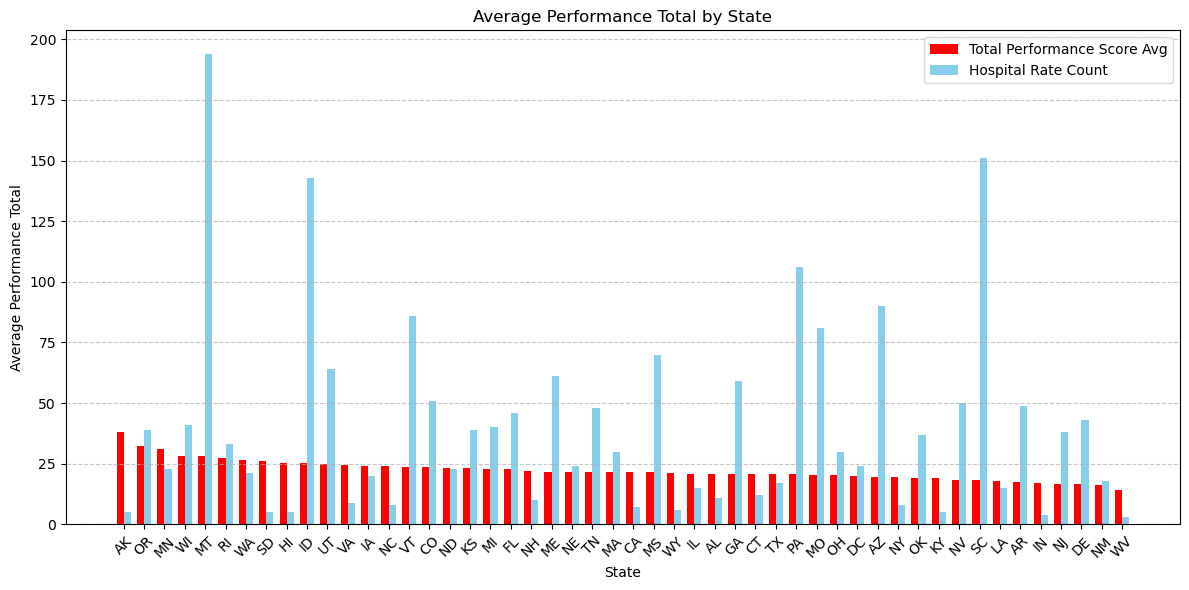

In [12]:

bar_width = 0.35

# Center positions for each group of bars
x = range(len(top_states.index))

# Plotting
plt.figure(figsize=(12, 6))

# Plot the first set of bars
plt.bar(x, top_states['Total Performance Score Avg'], width=bar_width, color='red', label='Total Performance Score Avg')

# Plot the second set of bars next to the first one
plt.bar([i + bar_width for i in x], by_state_df_count['Hospital Rate Count'], width=bar_width, color='skyblue', label='Hospital Rate Count')

plt.title('Average Performance Total by State')
plt.xlabel('State')
plt.ylabel('Average Performance Total')
plt.xticks([i + bar_width/2 for i in x], top_states.index, rotation=45)  # Rotating x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Define a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, xlabel, ylabel, title, coordinates):
    # Perform linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

    # Get regression values
    regress_values = x_values * slope + intercept

    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Create plot
    plt.scatter(x_values, y_values, edgecolors="black", alpha=0.75)
    plt.plot(x_values, regress_values, "r-", label=line_eq)

    # Annotate the line equation on the plot
    plt.annotate(line_eq, coordinates, fontsize=15, color="red")

    #Include Title with R-Value in title
    title_with_r = f"{title}\nR = {round(rvalue, 2)}"
    
    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title_with_r)
    
    # Show legend
    plt.legend()

    # Show plot
    plt.show()

#Weighted Normalized Clinical Outcomes Domain Score	Weighted Person And Community Engagement Domain Score	Weighted Safety Domain Score Weighted Efficiency And Cost Reduction Domain Score	Total Performance Score

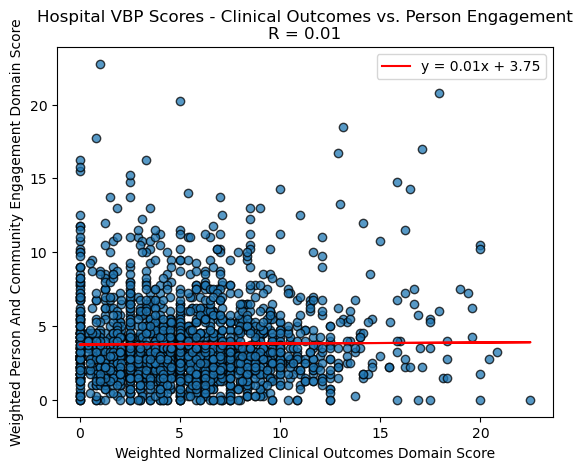

In [14]:
# Linear regression 

plot_linear_regression(new_hospital_data_df['Weighted Normalized Clinical Outcomes Domain Score'], new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], 
                       'Weighted Normalized Clinical Outcomes Domain Score', 
                       'Weighted Person And Community Engagement Domain Score', 
                       'Hospital VBP Scores - Clinical Outcomes vs. Person Engagement', (10, 270))

plt.show()


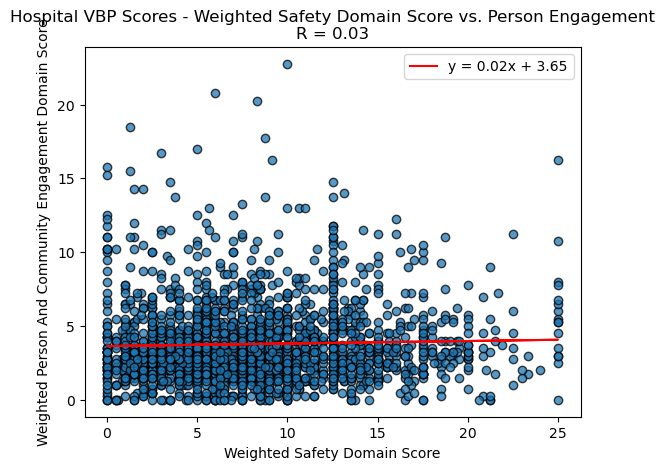

In [15]:
plot_linear_regression(new_hospital_data_df['Weighted Safety Domain Score'], new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], 
                       'Weighted Safety Domain Score', 
                       'Weighted Person And Community Engagement Domain Score', 
                       'Hospital VBP Scores - Weighted Safety Domain Score vs. Person Engagement', (10, 270))

plt.show()

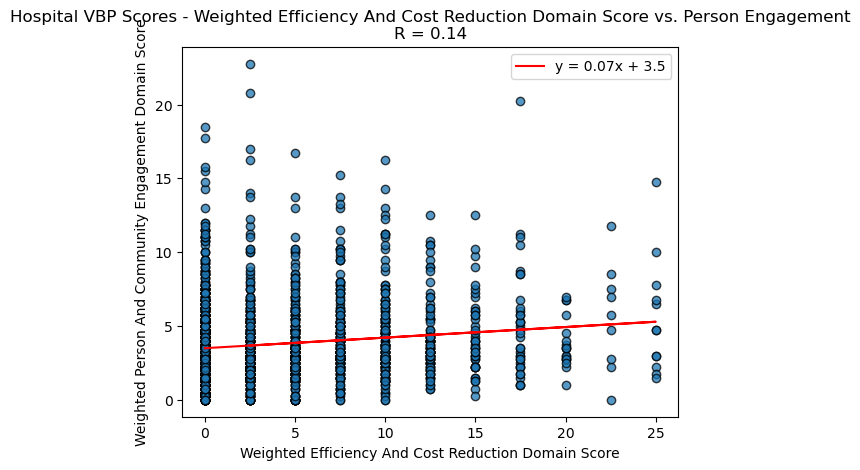

In [16]:
plot_linear_regression(new_hospital_data_df['Weighted Efficiency And Cost Reduction Domain Score'], new_hospital_data_df['Weighted Person And Community Engagement Domain Score'], 
                       'Weighted Efficiency And Cost Reduction Domain Score', 
                       'Weighted Person And Community Engagement Domain Score', 
                       'Hospital VBP Scores - Weighted Efficiency And Cost Reduction Domain Score vs. Person Engagement', (10, 270))
plt.show()

In [17]:
print(new_hospital_data_df['Hospital Ownership'].value_counts())


Hospital Ownership
Voluntary non-profit - Private                 962
Proprietary                                    371
Voluntary non-profit - Other                   214
Voluntary non-profit - Church                  205
Government - Hospital District or Authority    138
Government - Local                              82
Government - State                              33
Government - Federal                             6
Physician                                        6
Name: count, dtype: int64


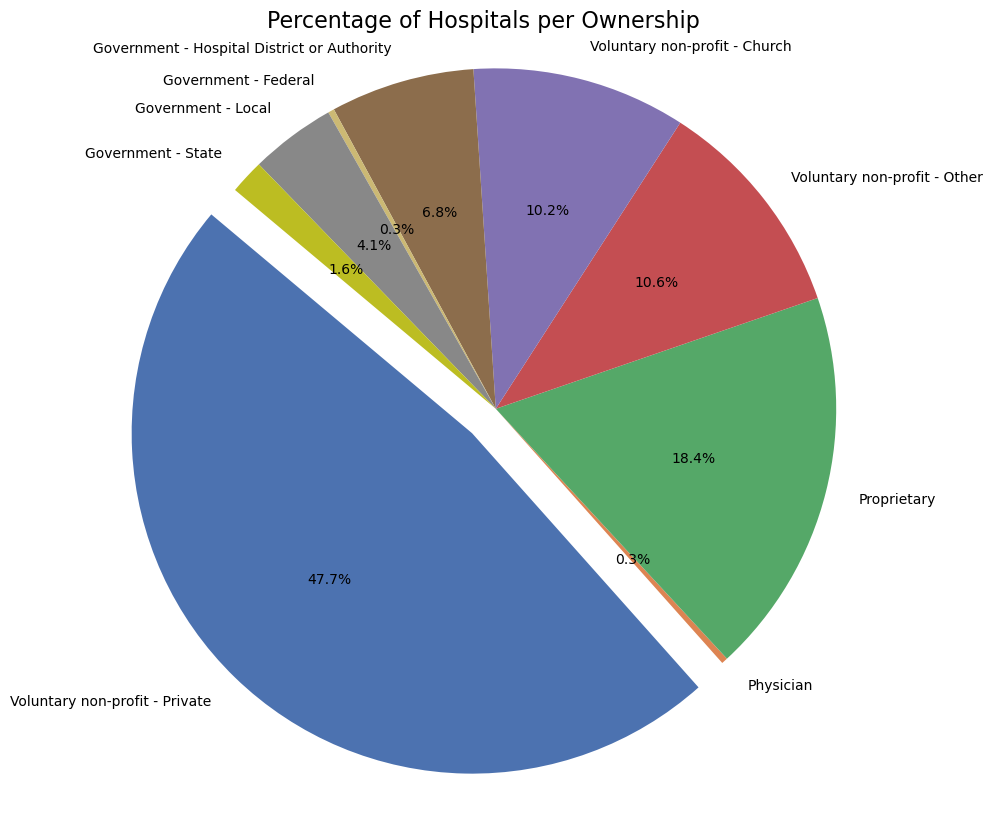

In [18]:
# Sample data
data = {'Hospital Ownership':['Voluntary non-profit - Private', 'Physician','Proprietary', 'Voluntary non-profit - Other', 
                         'Voluntary non-profit - Church','Government - Hospital District or Authority','Government - Federal','Government - Local','Government - State'],
        'Values':[962, 6, 371, 214, 205, 138, 6, 82, 33]}

hospital_df = pd.DataFrame(data)

# Calculate percentage of hospitals per type
total_hospitals = hospital_df['Values'].sum()
hospital_df['Percentage'] = (hospital_df['Values'] / total_hospitals) * 100

# Explode settings
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0)  # explode the first slice

# Custom colors
colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b2', '#8c6d4c', '#ccb974', '#888888', '#bcbd22']

# Plot
plt.figure(figsize=(10, 10))  # Adjust figure size
plt.pie(hospital_df['Percentage'], labels=hospital_df['Hospital Ownership'], autopct='%1.1f%%', explode=explode, startangle=140, shadow=False, colors=colors)
plt.title('Percentage of Hospitals per Ownership', fontsize=16)  # Adjust title font size
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjusting font size and label rotation
plt.xticks(fontsize=10, rotation=75)
plt.yticks(fontsize=10)

plt.show()


In [85]:

performance_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Total Performance Score"].mean()
clinical_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')['Weighted Normalized Clinical Outcomes Domain Score'].mean()
person_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Weighted Person And Community Engagement Domain Score"].mean()
safety_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Weighted Safety Domain Score"].mean()
efficiency_ownership_mean = new_hospital_data_df.groupby('Hospital Ownership')["Weighted Efficiency And Cost Reduction Domain Score"].mean()

hospital_by_ownership=pd.DataFrame({'Weighted Normalized Clinical Outcomes Domain Score Avg':clinical_ownership_mean,
                          'Weighted Person And Community Engagement Domain Score Avg':person_ownership_mean, 'Weighted Safety Domain Score Avg':safety_ownership_mean,
                          'Weighted Efficiency And Cost Reduction Domain Score Avg':efficiency_ownership_mean, 
                          'Total Performance Score Avg':performance_ownership_mean})

hospital_by_ownership

,Weighted Normalized Clinical Outcomes Domain Score Avg,Weighted Person And Community Engagement Domain Score Avg,Weighted Safety Domain Score Avg,Weighted Efficiency And Cost Reduction Domain Score Avg,Total Performance Score Avg
Hospital Ownership,,,,,
Government - Federal,5.305556,3.333333,8.736111,9.583333,26.958333
Government - Hospital District or Authority,4.135568,4.311594,8.331522,3.876812,20.655495
Government - Local,3.939024,3.923780,7.754573,4.390244,20.007622
Government - State,6.060606,4.325758,5.295455,3.560606,19.242424
Physician,3.020833,6.833333,11.020833,1.666667,22.541667
Proprietary,5.272350,2.994609,9.787848,2.823450,20.878257
Voluntary non-profit - Church,5.489024,3.759756,7.968902,4.121951,21.339634
Voluntary non-profit - Other,5.827687,3.837617,8.208917,4.988318,22.862539
Voluntary non-profit - Private,5.713401,3.967775,7.891026,4.132017,21.704219


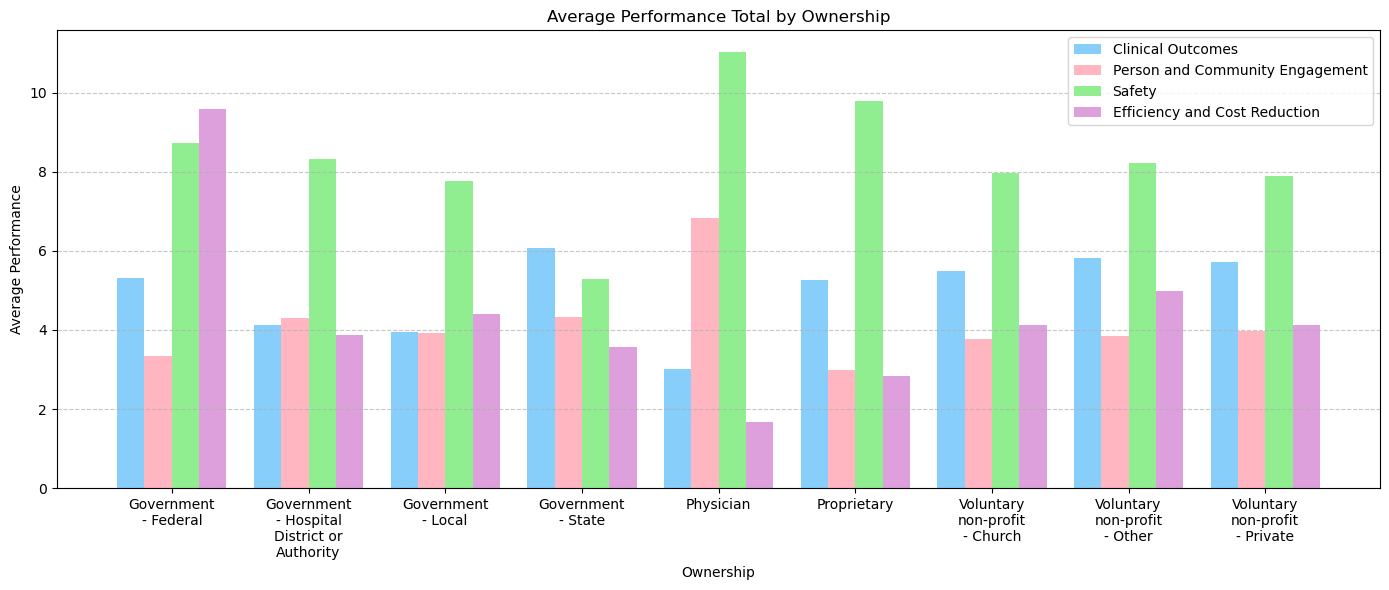

In [100]:
bar_width = 0.20

# Center positions for each group of bars
x = range(len(hospitals_by_ownership))

# Plotting
plt.figure(figsize=(14, 6))

# Plot the first set of bars
plt.bar([i - 1.5 * bar_width for i in x], hospital_by_ownership['Weighted Normalized Clinical Outcomes Domain Score Avg'], width=bar_width, color='lightskyblue', label='Clinical Outcomes')

# Plot the second set of bars next to the first one
plt.bar([i - 0.5 * bar_width for i in x], hospital_by_ownership['Weighted Person And Community Engagement Domain Score Avg'], width=bar_width, color='lightpink', label='Person and Community Engagement')

# Plot the third set of bars next to the second one
plt.bar([i + 0.5 * bar_width for i in x], hospital_by_ownership['Weighted Safety Domain Score Avg'], width=bar_width, color='lightgreen', label='Safety')

# Plot the fourth set of bars next to the third one
plt.bar([i + 1.5 * bar_width for i in x], hospital_by_ownership['Weighted Efficiency And Cost Reduction Domain Score Avg'], width=bar_width, color='plum', label='Efficiency and Cost Reduction')

from textwrap import wrap

# Custom tick label formatter to wrap the labels
def wrap_labels(labels, width=11):
    wrapped_labels = ['\n'.join(wrap(label, width)) for label in labels]
    return wrapped_labels

# Assuming x is defined as the center positions for each group of bars

# Wrapping tick labels
wrapped_labels = wrap_labels(hospital_by_ownership.index, width=11)
plt.xticks(x, wrapped_labels)

plt.title('Average Performance Total by Ownership')
plt.xlabel('Ownership')
plt.ylabel('Average Performance')
#plt.xticks([i for i in x], hospital_by_ownership.index, rotation=80)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for index, row in new_hospital_data_df.iterrows():
    zip_code = row['ZIP Code']  # Replace with the name of the column containing zip codes
    census_data = get_census_data(zip_code)

census_data.head()

In [33]:
census_data = c.acs5.get(
    (
        "NAME",
        "B19013_001E",
        "B01003_001E",
        "B01002_001E",
        "B19301_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column renaming
census_pd = census_pd.rename(
    columns = {
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "NAME": "Name",
        "zip code tabulation area": "Zipcode"
    }
)

# Add a Poverty Rate column (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Configure the final DataFrame
census_pd = census_pd[
    [
        "Zipcode",
        "Population",
        "Median Age",
        "Household Income",
        "Per Capita Income",
        "Poverty Count",
        "Poverty Rate"
    ]
]

census_pd['Zipcode'] = census_pd['Zipcode'].astype(int)
# Display DataFrame length and sample data
print(f"Number of rows in the DataFrame: {len(census_pd)}")
census_pd.head()

Number of rows in the DataFrame: 33774


,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,601,16834.0,44.0,17526.0,9012.0,10440.0,62.017346
1,602,37642.0,45.2,20260.0,11379.0,17768.0,47.202593
2,603,49075.0,45.0,17703.0,13010.0,23551.0,47.989812
3,606,5590.0,46.2,19603.0,9274.0,3021.0,54.042934
4,610,25542.0,44.4,22796.0,12726.0,11597.0,45.403649


In [49]:
hospital_census_df=pd.merge(new_hospital_data_df, census_pd, how="left", left_on='ZIP Code', right_on="Zipcode")

# Make an output for the new dataset
#output_file_path= 'hospital_data_complete.csv'
#hospital_data_complete.to_csv(output_file_path, index=False)
#hospital_data_complete=pd.read_csv(output_file_path)

hospital_census_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,2.0,0.0,15.583333,36301.0,38101.0,39.4,47414.0,28880.0,8279.0,21.729088
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,5.5,7.5,21.500000,35957.0,16269.0,36.4,46799.0,23239.0,3174.0,19.509497
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,12.0,0.0,13.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,...,4.0,2.5,14.250000,35235.0,20043.0,37.5,59476.0,31057.0,3836.0,19.138851
4,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,17.5,0.0,24.125000,35968.0,4870.0,39.6,54766.0,23024.0,835.0,17.145791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,BELL,2549538342,Acute Care Hospitals,Proprietary,...,12.5,0.0,21.500000,76548.0,32608.0,34.1,71845.0,33867.0,3880.0,11.898921
2013,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,COLLIN,4697642200,Acute Care Hospitals,Voluntary non-profit - Private,...,11.5,2.5,29.250000,75071.0,66298.0,37.6,124763.0,51262.0,3694.0,5.571812
2014,670085,TEXAS HEALTH HARRIS METHODIST HOSPITAL ALLIANCE,10864 TEXAS HEALTH TRAIL,FORT WORTH,TX,76244,TARRANT,6822122000,Acute Care Hospitals,Voluntary non-profit - Private,...,21.5,0.0,27.375000,76244.0,75185.0,34.7,116568.0,43262.0,3929.0,5.225776
2015,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,BRAZOS,9796913701,Acute Care Hospitals,Voluntary non-profit - Private,...,7.0,2.5,23.083333,77845.0,73969.0,32.2,87391.0,47345.0,9716.0,13.135232


In [50]:
hospital_census_df.count()

Provider ID                                              2017
Hospital Name                                            2017
Address                                                  2017
City                                                     2017
State                                                    2017
ZIP Code                                                 2017
County Name                                              2017
Phone Number                                             2017
Hospital Type                                            2017
Hospital Ownership                                       2017
Emergency Services                                       2017
Meets criteria for meaningful use of EHRs                2017
Hospital overall rating                                  2017
Weighted Normalized Clinical Outcomes Domain Score       2017
Weighted Person And Community Engagement Domain Score    2017
Weighted Safety Domain Score                             2017
Weighted

In [59]:
# First, drop rows with any NaN values
hospital_census_df = hospital_census_df.dropna(how='any')

hospital_census_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,2.0,0.0,15.583333,36301.0,38101.0,39.4,47414.0,28880.0,8279.0,21.729088
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,5.5,7.5,21.500000,35957.0,16269.0,36.4,46799.0,23239.0,3174.0,19.509497
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,...,4.0,2.5,14.250000,35235.0,20043.0,37.5,59476.0,31057.0,3836.0,19.138851
4,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,17.5,0.0,24.125000,35968.0,4870.0,39.6,54766.0,23024.0,835.0,17.145791
5,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,Acute Care Hospitals,Voluntary non-profit - Private,...,8.5,0.0,17.333333,35007.0,27052.0,39.7,81351.0,37693.0,1778.0,6.572527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,BELL,2549538342,Acute Care Hospitals,Proprietary,...,12.5,0.0,21.500000,76548.0,32608.0,34.1,71845.0,33867.0,3880.0,11.898921
2013,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,COLLIN,4697642200,Acute Care Hospitals,Voluntary non-profit - Private,...,11.5,2.5,29.250000,75071.0,66298.0,37.6,124763.0,51262.0,3694.0,5.571812
2014,670085,TEXAS HEALTH HARRIS METHODIST HOSPITAL ALLIANCE,10864 TEXAS HEALTH TRAIL,FORT WORTH,TX,76244,TARRANT,6822122000,Acute Care Hospitals,Voluntary non-profit - Private,...,21.5,0.0,27.375000,76244.0,75185.0,34.7,116568.0,43262.0,3929.0,5.225776
2015,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,BRAZOS,9796913701,Acute Care Hospitals,Voluntary non-profit - Private,...,7.0,2.5,23.083333,77845.0,73969.0,32.2,87391.0,47345.0,9716.0,13.135232


In [68]:
unweighted_census_df=pd.merge(hospital_unweighted, census_pd, how="left", left_on='ZIP Code', right_on="Zipcode")

# Make an output for the new dataset
#output_file_path= 'hospital_data_complete.csv'
#hospital_data_complete.to_csv(output_file_path, index=False)
#hospital_data_complete=pd.read_csv(output_file_path)

unweighted_census_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,8,0,15.583333,36301.0,38101.0,39.4,47414.0,28880.0,8279.0,21.729088
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,22,30,21.500000,35957.0,16269.0,36.4,46799.0,23239.0,3174.0,19.509497
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,48,0,13.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,...,16,10,14.250000,35235.0,20043.0,37.5,59476.0,31057.0,3836.0,19.138851
4,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,70,0,24.125000,35968.0,4870.0,39.6,54766.0,23024.0,835.0,17.145791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,BELL,2549538342,Acute Care Hospitals,Proprietary,...,50,0,21.500000,76548.0,32608.0,34.1,71845.0,33867.0,3880.0,11.898921
2013,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,COLLIN,4697642200,Acute Care Hospitals,Voluntary non-profit - Private,...,46,10,29.250000,75071.0,66298.0,37.6,124763.0,51262.0,3694.0,5.571812
2014,670085,TEXAS HEALTH HARRIS METHODIST HOSPITAL ALLIANCE,10864 TEXAS HEALTH TRAIL,FORT WORTH,TX,76244,TARRANT,6822122000,Acute Care Hospitals,Voluntary non-profit - Private,...,86,0,27.375000,76244.0,75185.0,34.7,116568.0,43262.0,3929.0,5.225776
2015,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,BRAZOS,9796913701,Acute Care Hospitals,Voluntary non-profit - Private,...,28,10,23.083333,77845.0,73969.0,32.2,87391.0,47345.0,9716.0,13.135232


In [69]:
unweighted_census_df = unweighted_census_df.dropna(how='any')

unweighted_census_df


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Unweighted Normalized Safety Domain Score,Unweighted Normalized Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,8,0,15.583333,36301.0,38101.0,39.4,47414.0,28880.0,8279.0,21.729088
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,22,30,21.500000,35957.0,16269.0,36.4,46799.0,23239.0,3174.0,19.509497
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Acute Care Hospitals,Voluntary non-profit - Private,...,16,10,14.250000,35235.0,20043.0,37.5,59476.0,31057.0,3836.0,19.138851
4,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,70,0,24.125000,35968.0,4870.0,39.6,54766.0,23024.0,835.0,17.145791
5,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,Acute Care Hospitals,Voluntary non-profit - Private,...,34,0,17.333333,35007.0,27052.0,39.7,81351.0,37693.0,1778.0,6.572527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,BELL,2549538342,Acute Care Hospitals,Proprietary,...,50,0,21.500000,76548.0,32608.0,34.1,71845.0,33867.0,3880.0,11.898921
2013,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,COLLIN,4697642200,Acute Care Hospitals,Voluntary non-profit - Private,...,46,10,29.250000,75071.0,66298.0,37.6,124763.0,51262.0,3694.0,5.571812
2014,670085,TEXAS HEALTH HARRIS METHODIST HOSPITAL ALLIANCE,10864 TEXAS HEALTH TRAIL,FORT WORTH,TX,76244,TARRANT,6822122000,Acute Care Hospitals,Voluntary non-profit - Private,...,86,0,27.375000,76244.0,75185.0,34.7,116568.0,43262.0,3929.0,5.225776
2015,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,BRAZOS,9796913701,Acute Care Hospitals,Voluntary non-profit - Private,...,28,10,23.083333,77845.0,73969.0,32.2,87391.0,47345.0,9716.0,13.135232


In [73]:
# Define a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, xlabel, ylabel, title, coordinates):
    # Perform linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

    # Get regression values
    regress_values = x_values * slope + intercept

    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Create plot
    plt.scatter(x_values, y_values, edgecolors="black", alpha=0.75)
    plt.plot(x_values, regress_values, "r-", label=line_eq)

    # Annotate the line equation on the plot
    plt.annotate(line_eq, coordinates, fontsize=15, color="red")

    #Include Title with R-Value in title
    title_with_r = f"{title}\nR = {round(rvalue, 2)}"
    
    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title_with_r)
    
    # Show legend
    plt.legend()

    # Show plot
    plt.show()

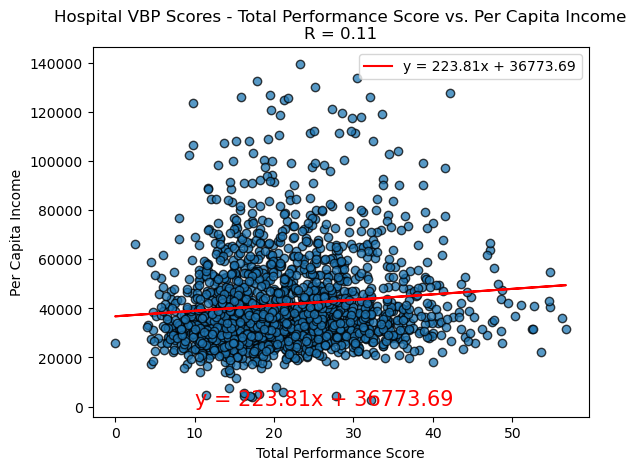

In [56]:
plot_linear_regression(hospital_census_df['Total Performance Score'], hospital_census_df['Per Capita Income'], 
                       'Total Performance Score', 
                       'Per Capita Income', 
                       'Hospital VBP Scores - Total Performance Score vs. Per Capita Income', (10, 270))
plt.show()

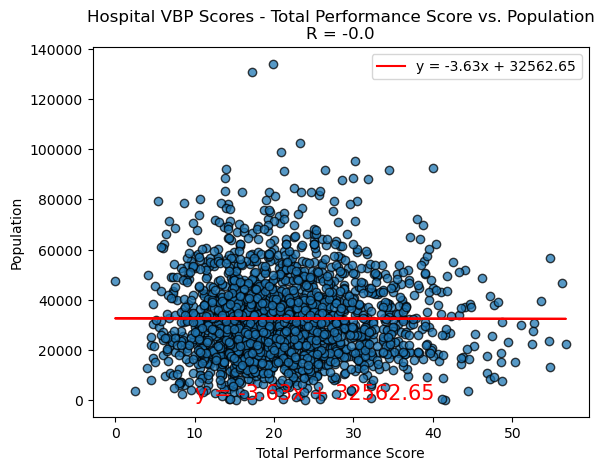

In [61]:
plot_linear_regression(hospital_census_df['Total Performance Score'], hospital_census_df['Population'], 
                       'Total Performance Score', 
                       'Population', 
                       'Hospital VBP Scores - Total Performance Score vs. Population', (10, 270))
plt.show()

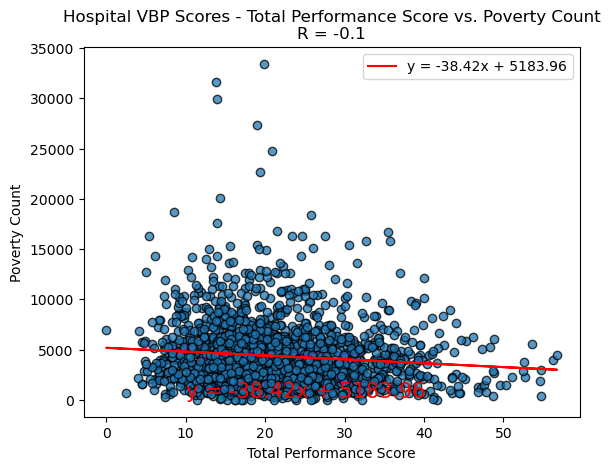

In [60]:
plot_linear_regression(hospital_census_df['Total Performance Score'], hospital_census_df['Poverty Count'], 
                       'Total Performance Score', 
                       'Poverty Count', 
                       'Hospital VBP Scores - Total Performance Score vs. Poverty Count', (10, 270))
plt.show()

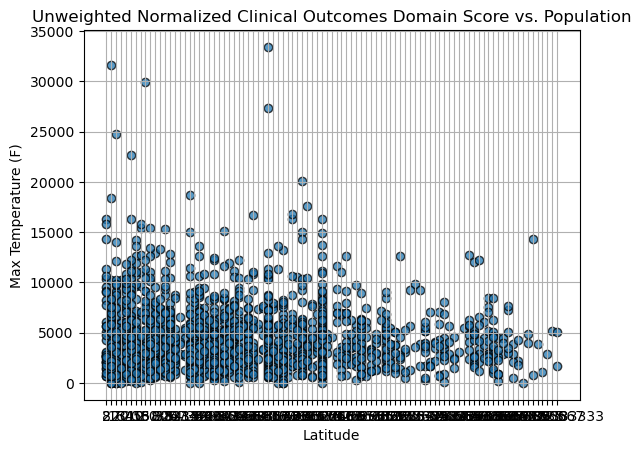

In [107]:
  # Create plot
# Build scatter plot for latitude vs. temperature
# YOUR CODE HERE
plt.scatter(unweighted_census_df["Unweighted Normalized Safety Domain Score"],unweighted_census_df['Poverty Count'], edgecolors="black", alpha=0.75)
# Incorporate the other graph properties
# YOUR CODE HERE
plt.title("Unweighted Normalized Clinical Outcomes Domain Score vs. Population")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid(True)
# Save the figure
#plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()





In [113]:
# Sort the schools by `% Overall Passing` in descending order and display the top 5 rows.
top_hospitals =hospital_census_df.sort_values(["Total Performance Score"], ascending=False) 
top_hospitals.head(10)


#locations_data
#hospital_census_df=pd.merge(hospital_census_data_df, census_pd, how="left", left_on='ZIP Code', right_on="Zipcode")

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
1496,380050,SKY LAKES MEDICAL CENTER,2865 DAGGETT AVENUE,KLAMATH FALLS,OR,97601,KLAMATH,5412746150,Acute Care Hospitals,Voluntary non-profit - Private,...,21.500000,25.0,56.750000,97601.0,22302.0,40.2,52951.0,31435.0,4498.0,20.168595
925,230072,HOLLAND COMMUNITY HOSPITAL,602 MICHIGAN AVE,HOLLAND,MI,49423,OTTAWA,6163925141,Acute Care Hospitals,Voluntary non-profit - Private,...,22.500000,17.5,56.250000,49423.0,46467.0,35.2,75164.0,35952.0,4000.0,8.608260
1018,250167,METHODIST HEALTHCARE - OLIVE BRANCH HOSPITAL,4250 BETHEL ROAD,OLIVE BRANCH,MS,38654,DESOTO,6629329000,Acute Care Hospitals,Voluntary non-profit - Private,...,25.000000,17.5,54.750000,38654.0,56449.0,38.8,96145.0,40702.0,2939.0,5.206470
960,230259,ST JOSEPH MERCY CHELSEA,775 S MAIN ST,CHELSEA,MI,48118,WASHTENAW,7344753911,Acute Care Hospitals,Voluntary non-profit - Private,...,12.500000,25.0,54.750000,48118.0,13001.0,49.1,89125.0,54661.0,355.0,2.730559
1777,450604,HILL COUNTRY MEMORIAL HOSPITAL INC,1020 SOUTH STATE HIGHWAY 16,FREDERICKSBURG,TX,78624,GILLESPIE,8309974353,Acute Care Hospitals,Voluntary non-profit - Private,...,25.000000,10.0,54.583333,78624.0,23538.0,49.8,71082.0,43152.0,1910.0,8.114538
587,130014,WEST VALLEY MEDICAL CENTER,1717 ARLINGTON STREET,CALDWELL,ID,83605,CANYON,2084594641,Acute Care Hospitals,Proprietary,...,25.000000,17.5,53.583333,83605.0,39636.0,31.5,58952.0,22059.0,5545.0,13.989807
40,20006,MAT-SU REGIONAL MEDICAL CENTER,2500 SOUTH WOODWORTH LOOP,PALMER,AK,99645,MATANUSKA SUSITNA,9078616000,Acute Care Hospitals,Voluntary non-profit - Private,...,20.000000,25.0,52.750000,99645.0,30849.0,35.8,93242.0,40987.0,2324.0,7.533469
1951,520002,MINISTRY ST MICHAELS HOSPITAL OF STEVENS POINT,900 ILLINOIS AVE,STEVENS POINT,WI,54481,PORTAGE,7153465000,Acute Care Hospitals,Voluntary non-profit - Church,...,25.000000,20.0,52.583333,54481.0,27544.0,30.7,55922.0,31552.0,3791.0,13.763433
928,230081,MUNSON HEALTHCARE CADILLAC HOSPITAL,400 HOBART ST,CADILLAC,MI,49601,WEXFORD,2318767200,Acute Care Hospitals,Voluntary non-profit - Church,...,17.500000,25.0,52.500000,49601.0,22300.0,43.1,61186.0,31643.0,2848.0,12.771300
1491,380022,SAMARITAN ALBANY GENERAL HOSPITAL,1046 6TH AVENUE SW,ALBANY,OR,97321,LINN,5418124000,Acute Care Hospitals,Voluntary non-profit - Church,...,8.333333,17.5,51.083333,97321.0,29970.0,40.6,93617.0,41274.0,2321.0,7.744411


In [125]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
top_ten_df=hospital_census_df.loc[hospital_census_df["Total Performance Score"] >45]
# Display sample data
top_ten_df

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Weighted Safety Domain Score,Weighted Efficiency And Cost Reduction Domain Score,Total Performance Score,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
33,10130,ST VINCENT'S ST CLAIR,7063 VETERANS PARKWAY,PELL CITY,AL,35125,SAINT CLAIR,2053383301,Acute Care Hospitals,Voluntary non-profit - Private,...,12.500000,22.5,46.750000,35125.0,10759.0,36.5,61865.0,29082.0,1297.0,12.055024
40,20006,MAT-SU REGIONAL MEDICAL CENTER,2500 SOUTH WOODWORTH LOOP,PALMER,AK,99645,MATANUSKA SUSITNA,9078616000,Acute Care Hospitals,Voluntary non-profit - Private,...,20.000000,25.0,52.750000,99645.0,30849.0,35.8,93242.0,40987.0,2324.0,7.533469
74,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,MARICOPA,4803424201,Acute Care Hospitals,Voluntary non-profit - Private,...,6.000000,2.5,47.166667,85054.0,8394.0,37.8,85656.0,63847.0,1148.0,13.676436
162,50135,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,6245 DE LONGPRE AVE,HOLLYWOOD,CA,90028,LOS ANGELES,3234622271,Acute Care Hospitals,Proprietary,...,21.250000,5.0,48.750000,90028.0,30982.0,36.5,57258.0,47369.0,6020.0,19.430637
308,60012,CENTURA HEALTH-ST MARY CORWIN MEDICAL CENTER,1008 MINNEQUA AVE,PUEBLO,CO,81004,PUEBLO,7195574000,Acute Care Hospitals,Voluntary non-profit - Church,...,18.750000,15.0,45.250000,81004.0,26261.0,38.2,46827.0,25749.0,5881.0,22.394425
532,110042,WELLSTAR PAULDING HOSPITAL,2518 JIMMY LEE SMITH PARKWAY,HIRAM,GA,30141,PAULDING,4706447000,Acute Care Hospitals,Voluntary non-profit - Other,...,12.500000,17.5,47.500000,30141.0,25416.0,37.7,82791.0,34283.0,1525.0,6.000157
587,130014,WEST VALLEY MEDICAL CENTER,1717 ARLINGTON STREET,CALDWELL,ID,83605,CANYON,2084594641,Acute Care Hospitals,Proprietary,...,25.000000,17.5,53.583333,83605.0,39636.0,31.5,58952.0,22059.0,5545.0,13.989807
608,140063,RUSH OAK PARK HOSPITAL,520 S MAPLE AVE,OAK PARK,IL,60304,COOK,7083839300,Acute Care Hospitals,Voluntary non-profit - Church,...,20.000000,15.0,46.750000,60304.0,17564.0,39.0,130290.0,61892.0,809.0,4.606012
769,170200,"VIA CHRISTI HOSPITAL WICHITA ST TERESA, INC",14800 WEST ST TERESA,WICHITA,KS,67235,SEDGWICK,3167967800,Acute Care Hospitals,Voluntary non-profit - Church,...,17.500000,12.5,48.625000,67235.0,15138.0,37.3,113513.0,43821.0,352.0,2.325274
771,180002,WHITESBURG ARH HOSPITAL,240 HOSPITAL ROAD,WHITESBURG,KY,41858,LETCHER,6066333500,Acute Care Hospitals,Voluntary non-profit - Other,...,18.750000,22.5,48.750000,41858.0,7473.0,41.3,40038.0,25988.0,2710.0,36.263883


In [126]:
locations_data
top_ten_location=pd.merge(top_ten_df, locations_data, how="left", left_on='Hospital Name', right_on="NAME")
#top_ten_location.info()

top_ten_final=top_ten_location[['Hospital Name', 'State', 'Total Performance Score', 'LATITUDE', 'LONGITUDE']].copy()
top_ten_final


,Hospital Name,State,Total Performance Score,LATITUDE,LONGITUDE
0,ST VINCENT'S ST CLAIR,AL,46.750000,NaN,NaN
1,MAT-SU REGIONAL MEDICAL CENTER,AK,52.750000,61.562894,-149.258311
2,MAYO CLINIC HOSPITAL,AZ,47.166667,NaN,NaN
3,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,CA,48.750000,34.096391,-118.325235
4,CENTURA HEALTH-ST MARY CORWIN MEDICAL CENTER,CO,45.250000,38.233803,-104.622578
5,WELLSTAR PAULDING HOSPITAL,GA,47.500000,33.900728,-84.780726
6,WEST VALLEY MEDICAL CENTER,ID,53.583333,43.654328,-116.694276
7,RUSH OAK PARK HOSPITAL,IL,46.750000,41.878618,-87.803352
8,"VIA CHRISTI HOSPITAL WICHITA ST TERESA, INC",KS,48.625000,NaN,NaN
9,WHITESBURG ARH HOSPITAL,KY,48.750000,37.112927,-82.812522
